In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
# Edits
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import pylcp
import pylcp.atom as atom
from pylcp.common import cart2spherical
#plt.style.use('paper')

In [24]:
class gaussianBeam(pylcp.laserBeam):
    def __init__(self, kvec=np.array([1., 0., 0.]), pol=np.array([0., 0., 1.]), beta=1.,
                 delta=0., wb=1., r0=np.array([0.,0.,0.]), **kwargs):
        if callable(kvec):
            raise TypeError('kvec cannot be a function for a Gaussian beam.')

        if callable(pol):
            raise TypeError('Polarization cannot be a function for a Gaussian beam.')

        # Save the constant values (might be useful):
        self.con_kvec = kvec
        self.con_kmag = np.linalg.norm(kvec)
        self.con_khat = kvec/self.con_kmag
        self.con_pol = pol

        # Save the parameters specific to the Gaussian beam:
        self.beta_max = beta    # central saturation parameter
        self.wb = wb            # 1/e^2 radius
        self.wavelength = 2*np.pi/(np.linalg.norm(kvec))  
        self.zr = np.pi*self.wb**2/(self.wavelength)  # Rayleigh length
        self.r0 = r0    # Position of focus?

        # Define the global rotation matrix
        self.define_rotation_matrix()
        
        # Use super class to define delta(t):
        super().__init__(delta=delta, **kwargs)
   

    def global_rotation_matrix(self):
        th = np.arccos(self.con_khat[2])
        ph = np.arctan2(self.con_khat[1], self.con_khat[0])
        
        rz = np.array([[np.cos(ph),-np.sin(ph),0.], [np.sin(ph),np.cos(ph),0.], [0.,0.,1.]])
        ry = np.array([[np.cos(th),0.,np.sin(th)], [0.,1.,0.], [-np.sin(th),0.,np.cos(th)]])
        
        self.rmat = rz@ry@np.linalg.inv(rz)
        self.rmat_inv = np.linalg.inv(self.rmat)
        return self.rmat
    
    
    def define_rotation_matrix(self):
        # Angles of rotation:|
        th = np.arccos(self.con_khat[2])
        phi = np.arctan2(self.con_khat[1], self.con_khat[0])
        
        # Use scipy to define the rotation matrix
        self.rmat = Rotation.from_euler('ZY', [phi, th]).inv().as_matrix() 
        self.rmat_inv = np.linalg.inv(self.rmat)

        
    def local_parameters(self, R=np.array([0., 0., 0.]), t=0.):
        """
        Returns the local k-vector, polarization, and intensity and position R and t
        
        Parameters
        ----------
        R : array_like, shape (3, ...)
            The local position at which to evaluate.
        t : float or array_like
            The time at which to to evaluate.
            
        Returns
        -------
        kvec : array_like, same shape as R
            The k-vector of the beam at (R, t)
        pol : array_like, same shape as R
            The polarization of the beam at (R, t)
        intensity : float or array_like, same shape/type as R[0]
            The local intensity
        """
        
        # Adjust offset:
        Rp = R - self.r0.reshape((3,) + (1,)*(R.ndim-1))
    
        # Rotate up to the z-axis where we can apply formulas:
        Rp = np.einsum('ij,j...->i...', self.rmat, Rp)
        rho_sq=np.sum(Rp[:2]**2, axis=0)
       
        # The waist at the position of interest:
        w = self.wb*np.sqrt(1+(Rp[2]**2/self.zr**2)) # w0*sqrt(1+(z/zr).^2);
        
        # Return the intensity:
        I = self.beta_max*(self.wb**2)/(w**2)*np.exp(-2*rho_sq/w**2) #Beta*(w0./w).^2.*exp(-2*r.^2./w.^2);
        
        # Now calculate the local k-vector in cylindrical coordinates:
        kr = (np.sqrt(rho_sq))*(Rp[2])/(self.zr**2+Rp[2]**2) # r.*z./(zr^2+z.^2);
        kt = np.zeros(Rp[0].shape)
        kz = np.ones(Rp[0].shape)
        
        # Convert to Cartesian: 
        kx = (kr*Rp[0]+kt*Rp[1])/(np.sqrt(Rp[0]**2+Rp[1]**2+1e-100))
        ky = (kr*Rp[1]+kt*Rp[0])/(np.sqrt(Rp[0]**2+Rp[1]**2+1e-100))
        
        # Normalize:
        kxn=kx/np.sqrt(kx**2+ky**2+kz**2) # normalized
        kyn=ky/np.sqrt(kx**2+ky**2+kz**2)
        kzn=kz/np.sqrt(kx**2+ky**2+kz**2)
        
        # Put into full array:
        kn=np.array([kxn,kyn,kzn])
        
        # Rotate back:
        k = np.einsum('ij,j...->i...', self.rmat_inv, kn)
        
        # Think about a way to do this without having to this without the FOR loop:
        it = np.nditer([kn[0], kn[1], kn[2], None, None, None])
        for (kxn, kyn, kzn, px, py, pz) in it:       
            thn = np.arccos(kzn)
            phn = np.arctan2(kyn, kxn)
            
            rzn = np.array([[np.cos(phn), -np.sin(phn), 0.],
                            [np.sin(phn),  np.cos(phn), 0.],
                            [         0.,           0., 1.]])
            ryn = np.array([[np.cos(thn),  0., np.sin(thn)],
                            [0.,           1.,          0.],
                            [-np.sin(thn), 0., np.cos(thn)]])
            
            rmatn = rzn@ryn@np.linalg.inv(rzn)

            (px[...], py[...], pz[...]) = self.rmat@rmatn@np.transpose(self.con_pol)
        
        return k, np.array(it.operands[3:]), I
    
    
    def beta(self, R=np.array([0., 0., 0.]), t=0.):
        k, P, I = self.local_parameters(R, t)
        return I
    
    def pol(self, R=np.array([0., 0., 0.]), t=0.):
        k, P, I = self.local_parameters(R, t)
        return P
    
    def kvec(self, R=np.array([0., 0., 0.]), t=0.):
        k, P, I = self.local_parameters(R, t)
        return k

In [25]:
k = np.array([1., 1., 1.])
k = k/np.linalg.norm(k)
laserBeam = gaussianBeam(kvec=np.array([0., 0., 1.]), wb=20., pol=np.array([1., 1.j, 0]), r0=np.array([0., 0., 0.]))
laserBeam.local_parameters(np.array([100., 10., 1.]), 0.)

/Users/steve/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: ComplexWarning: Casting complex values to real discards the imaginary part


(array([2.49992961e-03, 2.49992961e-04, 9.99996844e-01]),
 array([ 9.99996875e-01, -3.12482896e-07, -2.49992961e-03]),
 1.1712944615516224e-22)

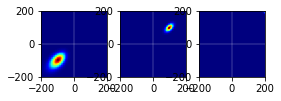

In [41]:
x_beta = 200
X, Y = np.meshgrid(np.linspace(-x_beta, x_beta, 101),
                   np.linspace(-x_beta, x_beta, 101))
z_tests = [-1*laserBeam.zr, 0, laserBeam.zr] # position

plt.figure("Laser Beams", figsize=(4, 1.5*6)) # 6 beams
plt.clf()
# pr = cProfile.Profile()

for ii, z_test in enumerate(z_tests):
    Z = z_test*np.ones(X.shape)
    Rt=np.array([X, Y, Z])

    #pr.enable()
    """it = np.nditer([X, Y, Z, None])
    for (x, y, z, beta) in it:
        beta[...] = laserBeam.beta(np.array([x, y, z]), 0.)
    BETA = it.operands[3]"""
    #pr.disable()
    
    #pr.enable()
    BETA = laserBeam.beta(Rt)
    #pr.disable()

    plt.subplot(1., len(z_tests), ii+1)
    plt.imshow(BETA, origin='lower',
               extent=(-x_beta, x_beta,
                       -x_beta, x_beta))
    # plt.clim((0, 1))
    plt.set_cmap('jet')
    # Make a cross-hair:
    plt.plot([0, 0], [-x_beta, x_beta],
             'w-', linewidth=0.25)
    plt.plot([-x_beta, x_beta], [0, 0],
             'w-', linewidth=0.25)

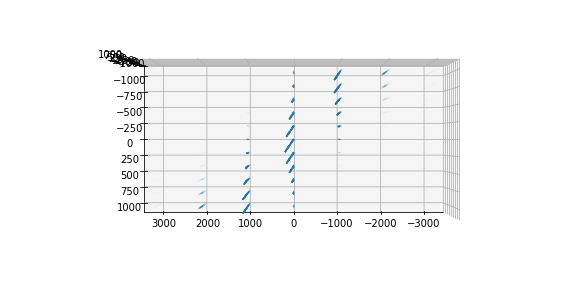

In [42]:
# def axisEqual3D(ax):
#     extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
#     sz = extents[:,1] - extents[:,0]
#     centers = np.mean(extents, axis=1)
#     maxsize = max(abs(sz))
#     r = maxsize/2
#     for ctr, dim in zip(centers, 'xyz'):
#         getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

laserBeam = gaussianBeam(kvec=2*np.pi/461.*np.array([1.,1.,0.])/np.sqrt(2), wb=500., pol=1., r0=np.array([0.,0.,0.])) # Change the laser beam attributes

fig = plt.figure(figsize=(10,5)) # Change the size of the plot
ax = fig.gca(projection='3d')

# Make the grid
z, y, x = np.meshgrid(np.arange(-1000., 1001., 200.),
                      np.arange(-1000., 1001., 200.),
                      np.arange(-3000., 3001., 1000.)) # Change the axis

Rt=np.array([x, y, z])

# Make the direction data for the arrows
# u = np.sin(np.pi * x) * np.cos(np.pi * y) * np.cos(np.pi * z)
# v = -np.cos(np.pi * x) * np.sin(np.pi * y) * np.cos(np.pi * z)
# w = (np.sqrt(2.0 / 3.0) * np.cos(np.pi * x) * np.cos(np.pi * y) *
#      np.sin(np.pi * z))


arr = laserBeam.kvec(Rt)*20000
kx = arr[0]
ky = arr[1]
kz = arr[2]

i = laserBeam.beta(Rt)

ax.quiver(x,y,z,i*kx,i*ky,i*kz)
ax.view_init(90, 90) # change this to see different viewing angles

plt.show()

[[array([[ 0.70710678,  0.70710678,  0.70710678, -1.        , -0.70710678,
        -0.70710678, -0.70710678],
       [ 0.58123819,  0.58123819,  0.58123819, -1.        , -0.58123819,
        -0.58123819, -0.58123819],
       [ 0.3939193 ,  0.3939193 ,  0.3939193 , -1.        , -0.3939193 ,
        -0.3939193 , -0.3939193 ],
       [ 0.14142136,  0.14142136,  0.14142136, -1.        , -0.14142136,
        -0.14142136, -0.14142136],
       [-0.14142136, -0.14142136, -0.14142136,  1.        ,  0.14142136,
         0.14142136,  0.14142136],
       [-0.3939193 , -0.3939193 , -0.3939193 ,  1.        ,  0.3939193 ,
         0.3939193 ,  0.3939193 ],
       [-0.58123819, -0.58123819, -0.58123819,  1.        ,  0.58123819,
         0.58123819,  0.58123819]])
  array([[-7.07106781e-01, -7.07106781e-01, -7.07106781e-01,
         1.22464680e-16,  7.07106781e-01,  7.07106781e-01,
         7.07106781e-01],
       [-8.13733471e-01, -8.13733471e-01, -8.13733471e-01,
         1.22464680e-16,  8.13733471

TypeError: No loop matching the specified signature and casting was found for ufunc inv

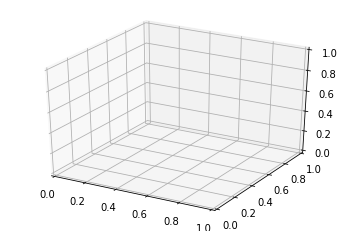

In [43]:
laserBeam = gaussianBeam(kvec=2*np.pi/461.*np.array([0.,0.,1.]), wb=200., pol=np.array([1,1j,0])/np.sqrt(2), r0=np.array([100.,100.,0.])) # Change the laser beam attributes

fig = plt.figure() # Change the size of the plot
ax = fig.gca(projection='3d')

# Make the grid
x, y, z = np.meshgrid(np.arange(-600., 601., 200.),
                      np.arange(-600., 601., 200.),
                      np.arange(-600., 601., 200.)) # Change the axis

Rt=np.array([x, y, z])

arr = laserBeam.kvec(Rt)*20000
kx = arr[0]
ky = arr[1]
kz = arr[2]

i = laserBeam.beta(Rt)

arr1 = laserBeam.cartesian_pol(Rt)*20000
p0 = arr1[0]
p1 = arr1[1]
p2 = arr1[2]

#quiver3(r(:,1),r(:,2),r(:,3),Ip.*k(:,1),Ip.*k(:,2),Ip.*k(:,3),'k')
ax.quiver(x,y,z,i*kx,i*ky,i*kz)

#quiver3(r(:,1),r(:,2),r(:,3),Ip.*real(P(:,1)),Ip.*real(P(:,2)),Ip.*real(P(:,3)),'r')
ax.quiver(x,y,z,i*np.real(p0),i*np.real(p1),i*np.real(p2))

#quiver3(r(:,1),r(:,2),r(:,3),Ip.*imag(P(:,1)),Ip.*imag(P(:,2)),Ip.*imag(P(:,3)),'b')
ax.quiver(x,y,z,i*np.imag(p0),i*np.imag(p1),i*np.imag(p2))

plt.show()